In [1]:
import torch
from torch import optim, nn
from torchvision import models, transforms

In [2]:
model = models.vgg16(pretrained=True)

/home/luba/.local/share/virtualenvs/ds-as-a-software-iy38ZIEu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/luba/.local/share/virtualenvs/ds-as-a-software-iy38ZIEu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
class FeatureExtractor(nn.Module):
    def __init__(self, model) -> None:
        super().__init__()
        # extract vgg16 feature layers
        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        # extract vgg16 avg pooling layer
        self.pooling = model.avgpool
        # convert the image into one-dimensional vector
        self.flatten = nn.Flatten()
        # extract the  first part of fully-connected layer from vgg16
        self.fc = model.classifier[0]

    def forward(self, x):
        # take the input x and return the feature vector called 'out'
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out
    



In [5]:
new_model = FeatureExtractor(model)

Putting the model on the gpu

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
new_model = new_model.to(device)

Feature extraction

In [168]:
# Check for any completely black or white images
import numpy as np
from matplotlib.image import imread

dark_th = 50 / 255                             # If no pixel reaches this threshold, image is considered too dark
bright_th = 220 / 255                          # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0

path = "./data/raw/histopathologic-cancer-detection/train_v2/"
files = os.listdir(path)

for i, file in tqdm_notebook(enumerate(files), 'Computing...(220.025 total files)'):
    file_path = os.path.join(path, file)
    imagearray = imread(file_path).reshape(-1,3)
    
    if((imagearray.max() / 255) < dark_th):            # is this too dark
        too_dark_idx.append(file)
        continue                                       # do not include in statistics
    
    if((imagearray.min() / 255) > bright_th):          # is this too bright
        too_bright_idx.append(file)
        continue                                       # do not include in statistics

print('There was {0} extremely dark image'.format(len(too_dark_idx)))
print('and {0} extremely bright images'.format(len(too_bright_idx)))
print('Dark one:')
print(too_dark_idx)
print('Bright ones:')
print(too_bright_idx)

/tmp/ipykernel_104681/2521634367.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, file in tqdm_notebook(enumerate(files), 'Computing...(220.025 total files)'):


Computing...(220.025 total files): 0it [00:00, ?it/s]

There was 4 extremely dark image
and 11 extremely bright images
Dark one:
['743f0fec3a423c4468c76e23fe84ee8bc902cf27.tif', 'cadbcd35b4b63261e8de56f8c4740ae2ece8a68a.tif', 'ce3d3e9dfbe51dfd3eeb93d9b5f48a7486aa54a5.tif', 'a21bc52891158bb06c848e442399ffbeb0d13490.tif']
Bright ones:
['db580e988038d686aac112f348b0fd8729d9ad5e.tif', '3d5bd46372cc887d4833bb52395a74120213572b.tif', 'b51d99e01a77456535b133d30bcfc956799ead4a.tif', 'cc301d753a549d78a28ff7744c1f4cff8ee12338.tif', '68889c64550e5d2e2a2b34483f1f58ac836eb167.tif', 'd66898924f7d01561b2e02c115d2ee3a44e9b60a.tif', 'b27c041a7da4cd4340ab1dadb7dfd879ce64835a.tif', '1a0a38342e54207a7cc0ee5b56eb1795a9a6729d.tif', '1237092e9aa7797c84c4f0618ce9d168b4e0f84a.tif', '3dace325166c5f4464137fb0a2a39c7b9a2669ad.tif', '9168b062233202e5919522cd05a6be04eeeeebc1.tif']


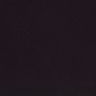

In [170]:
Image.open(path+"a21bc52891158bb06c848e442399ffbeb0d13490.tif")

In [25]:
from tqdm import tqdm_notebook
import numpy as np
import os
from PIL import Image

transform = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.Resize(448),
    transforms.ToTensor()
])

features = []

files = os.listdir("./data/raw/histopathologic-cancer-detection/train_v2")

for file in tqdm_notebook(files):
    img_path = "./data/raw/histopathologic-cancer-detection/train_v2/" + file
    img = Image.open(img_path)
    img = transform(img)
    img = img.reshape(1, 3, 448, 448)
    img = img.to(device)
    with torch.no_grad():
        feature = new_model(img)
        features.append(feature.cpu().detach().numpy().reshape(-1))

features = np.array(features)

/tmp/ipykernel_104681/1728116404.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(files):


  0%|          | 0/9407 [00:00<?, ?it/s]

In [11]:
# import pandas as pd

# pd.DataFrame(features).to_csv("./data/processed/cancer_features.csv", index=False)

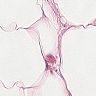

In [8]:
from PIL import Image

Image.open("./data/raw/histopathologic-cancer-detection/train_v2/00030ae10b490d6f1b114bd7ea7a222889e61baa.tif")

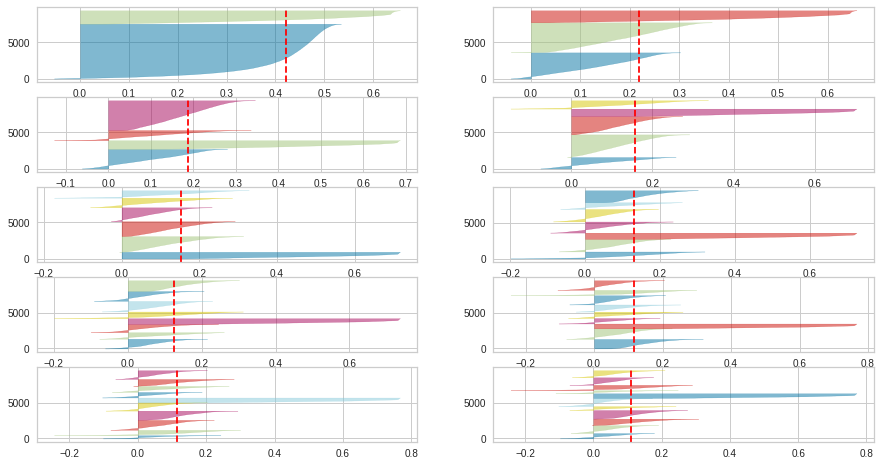

In [31]:
fig, ax = plt.subplots(5, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(features) 

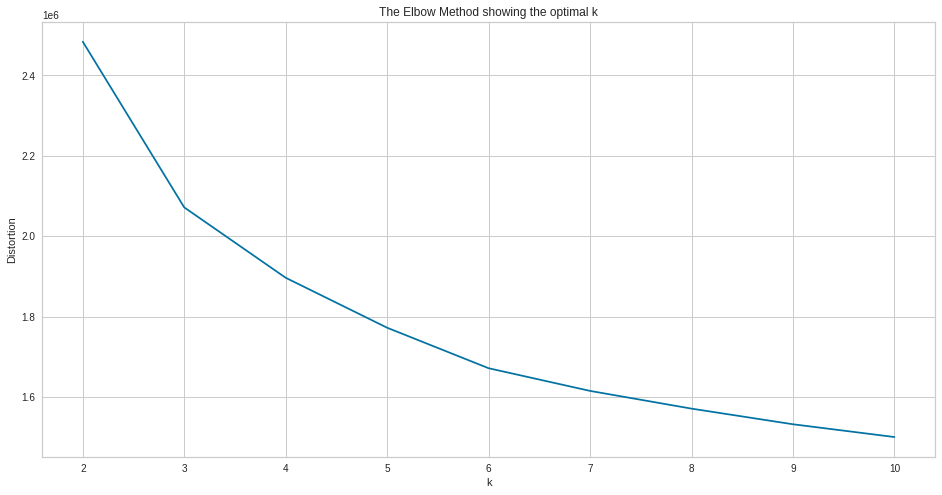

In [128]:
distortions = []
K = range(2,11)
for k in K:
    kmeansModel = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    kmeansModel.fit(features)
    distortions.append(kmeansModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [129]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
model.fit(features)
labels = model.labels_

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(max_iter=100, n_clusters=4,
                                      random_state=42))

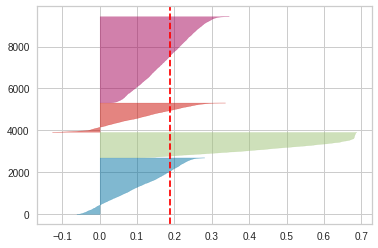

In [130]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(features)

- https://towardsdatascience.com/image-feature-extraction-using-pytorch-e3b327c3607a
- https://franky07724-57962.medium.com/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1
- https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
- https://www.youtube.com/watch?v=YdPOZzlo2kI

In [131]:
import pandas as pd

feat_df = pd.DataFrame(features)
feat_df["labels"] = model.labels_
feat_df["files"] = files

In [132]:
feat_df

,0,1,2,3,4,5,6,7,8,9,...,4088,4089,4090,4091,4092,4093,4094,4095,labels,files
0,0.190087,-0.139820,-1.680379,-1.397236,0.362709,-0.158097,-0.898454,-2.836072,-0.027179,-0.226114,...,-2.924101,0.212045,0.902482,0.590710,-2.010627,-0.917948,0.195296,-1.272736,0,7c92ffa222f7db5ea81fbba9654a04209e041ae8.tif
1,0.148631,-0.209770,-1.247376,-2.101739,-0.012629,0.212243,-1.106556,-3.168616,-0.038478,-0.280432,...,-2.971194,0.774613,1.244206,0.392012,-1.213458,-0.337413,-0.098468,-1.166406,3,fe83b6e2aac2e0f45ae2f86e74edf1c9c7305f7e.tif
2,0.119211,0.248843,-0.401241,-1.894664,-0.250142,0.228108,-0.688940,-2.379987,-0.151207,-0.250575,...,-1.630643,0.516382,0.354767,0.123901,-1.632634,-0.965621,0.129094,-0.764303,2,d48b8d6a8be797fe1fcc9a2a1e84c441a6777ad2.tif
3,-0.084257,-0.588655,-2.150344,-1.683122,-0.003141,0.164713,-0.953701,-3.833056,-0.301371,-0.621062,...,-2.969668,0.516263,1.073750,0.716192,-0.746902,-0.966553,-0.142140,-1.465444,0,e1242da9d0267f8367d1681c577bf58fd735185b.tif
4,-0.111611,-0.729177,-1.952496,-1.871396,0.246929,-0.111834,-1.489160,-3.545025,0.136487,-0.602611,...,-3.172675,0.700872,1.236379,0.440779,-1.325838,-0.771183,-0.112126,-1.705123,0,9c4338c8420332dcaa29a5da7d436f29dd0fea8d.tif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9402,-0.076502,-0.353849,-1.679524,-1.777738,-0.229576,-0.345561,-1.447555,-3.533027,-0.107167,-0.399193,...,-3.026056,0.623975,1.037542,0.055705,-1.827503,-0.618234,-0.035272,-1.293297,0,339dff37726c104fa7707339d1816093ca573cf2.tif
9403,0.145045,0.272906,0.081240,-1.384210,-0.092771,-0.103945,-0.330446,-1.734942,-0.307160,-0.384605,...,-0.621816,0.263616,-0.285990,-0.227650,-1.537884,-0.567749,0.164601,-0.451206,1,f830f2a22c00d1ccf5703eb60e0088eb73736395.tif
9404,0.220538,0.108628,-1.248983,-2.116898,-0.105457,0.627694,-0.860623,-3.026588,-0.228796,-0.224531,...,-2.756037,1.001945,0.969486,0.041655,-0.978974,-0.203844,-0.330808,-0.976462,3,b5a12937b60b837ea5a5690680ba47f94c4c5f76.tif
9405,0.458877,0.339151,-1.089268,-2.065898,0.113749,0.475956,-1.012016,-2.458187,-0.209336,-0.244339,...,-2.564240,0.696926,0.949390,-0.347255,-1.155268,-0.793624,-0.166724,-0.525086,2,e61ce670e276298cc140e76d5183c9be071c17db.tif


In [133]:
feat_df.sample(n=10)

,0,1,2,3,4,5,6,7,8,9,...,4088,4089,4090,4091,4092,4093,4094,4095,labels,files
826,0.169206,-0.344872,-1.814592,-1.894255,-0.095521,0.477917,-1.480051,-3.430135,0.332111,-0.558824,...,-2.982710,0.821014,1.303143,0.445216,-1.503228,-1.033031,-0.080784,-1.209624,0,08f0f52699c401c8bbe08b0b21c8c7e924faed78.tif
7585,0.245256,0.258332,-0.639215,-2.060512,0.044392,0.067769,-0.458857,-2.187258,-0.468920,-0.287565,...,-1.426628,0.396203,0.224421,-0.414237,-1.086076,-0.515825,-0.482981,-0.625511,2,572072f933f9b5364c42801b7a69b0033e88da80.tif
4986,0.224076,-0.590008,-1.762955,-1.723412,-0.263010,0.274780,-0.733314,-3.463472,-0.142340,-0.210506,...,-2.994478,0.624744,1.041761,0.404966,-1.224590,-0.664434,-0.250063,-1.089047,3,f0a705fada02835b3eafd7de392d1850b0966f20.tif
2300,0.101424,-0.387255,-1.330811,-2.046036,-0.230420,0.416278,-0.828748,-3.221702,-0.120541,-0.445478,...,-2.861516,0.875523,1.292327,0.322385,-1.022235,-0.790216,-0.337222,-0.843918,3,51a83138fb07f70fd4ffe78432f870f9f6488db9.tif
640,0.146698,0.283963,-1.312825,-1.955520,0.200099,0.325242,-0.901130,-2.442286,-0.160483,-0.097025,...,-2.662884,0.660820,0.917816,0.183141,-1.262331,-0.845629,0.075248,-0.843139,2,4075727c2095cfcf1216c8c2ca2b6fbc1c08e7da.tif
315,0.199112,-0.439555,-1.545708,-1.704265,-0.300896,0.784506,-1.327527,-3.427696,-0.096808,-0.369697,...,-3.576043,0.549825,1.719213,0.569017,-1.173707,-1.191000,0.321039,-1.298142,0,48bfe65e190d196810228f65d0891a15087911e7.tif
8476,0.072624,0.030968,-1.487293,-2.065922,0.226799,0.614895,-0.842380,-2.868783,-0.201121,-0.336418,...,-2.747027,0.678129,1.132511,0.070702,-0.758542,-0.577281,-0.360058,-0.781101,3,9251777f302c56e8f38018979f2c841519185b86.tif
2339,0.057816,-0.339334,-1.255462,-2.459508,0.016415,0.258897,-0.869582,-3.480651,-0.139260,-0.427831,...,-2.677009,0.978177,1.218112,0.087494,-1.088869,-0.218573,-0.229842,-1.084948,3,c51c7a26cdcec40f4133d4ae59a25506ea2b64e9.tif
6425,-0.231392,-0.375674,-1.968099,-1.708622,0.067489,-0.047179,-0.607108,-3.431467,-0.016464,-0.695531,...,-3.081669,0.654009,1.148718,0.445676,-1.063865,-0.574901,-0.034877,-0.994988,0,eb3d62be669dc63120b74932bcdbed66fc30da89.tif
8295,0.301310,0.195580,-1.398320,-2.093317,-0.083074,0.412672,-0.999636,-2.537833,0.336421,-0.478339,...,-2.829511,1.116108,1.154064,0.257067,-0.988882,-0.655367,-0.131539,-0.856529,3,30b70f57515a389237ab80eeb391bdd621333873.tif


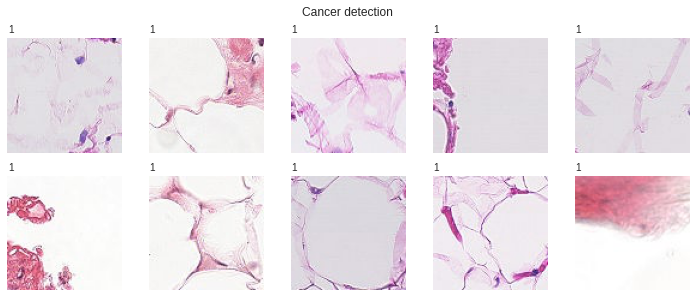

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.suptitle("Cancer detection")
feat_sample = feat_df[feat_df["labels"] == 1].sample(n=10).reset_index()
for i, row in feat_sample.iterrows():
    img_path = "./data/raw/histopathologic-cancer-detection/train_v2/" + row.files
    img = Image.open(img_path)
    label = row.labels
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.text(0, -5, label)
    plt.axis('off')

plt.tight_layout()
plt.show()